# Issue Clustering

This notebook clusters issue/feedback items from a CSV, evaluates against provided labels, and compares three strategies:

- Agglomerative clustering (cosine, threshold-based, batch)
- Vector-style incremental assignment (simulates vector DB neighbor-join)
- Centroid-style incremental assignment

It uses Gemini embeddings by default (set `GOOGLE_API_KEY`) or any SentenceTransformer model if you change `model_name`. Ensure `issues_raw.csv` exists with columns `title`, `body`, and optional `label`.

Add a `.env` file with `GOOGLE_API_KEY=your_key` if you want Gemini embeddings. To run offline, switch `model_name` to a SentenceTransformer model.

In [22]:
# Install dependencies
# !python3 -m venv venv && source venv/bin/activate && pip install -r requirements.txt

In [23]:
import os
from dotenv import load_dotenv
import pandas as pd
from IPython.display import display
import sklearn
from packaging import version
from google import genai

from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
import numpy as np

load_dotenv()

genai_client = genai.Client(api_key=os.getenv("GOOGLE_API_KEY")) if os.getenv("GOOGLE_API_KEY") else None

In [24]:
# =============================================================================
# CONFIGURATION - Set this for each repo you analyze
# =============================================================================
REPO_NAME = "facebook/react"  # e.g., "anthropics/claude-code", "facebook/react"
ISSUE_STATE = "open"  # "open", "closed", or "all"
MAX_ISSUES = None  # Set to None for no limit, or a number to cap

# Derived paths (auto-generated from REPO_NAME)
DATA_DIR = "data"
EMBEDDINGS_DIR = "embeddings"
RESULTS_DIR = "results"
FORCE_RECOMPUTE = False  # Set True to recompute embeddings even if cached

# Create directories
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(EMBEDDINGS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

def get_safe_name(repo_name):
    """Convert repo name to filesystem-safe name."""
    return repo_name.replace("/", "__").replace("\\", "__")

def get_csv_path(repo_name):
    """Get CSV path for a repo's issues."""
    return os.path.join(DATA_DIR, f"{get_safe_name(repo_name)}.csv")

def get_embedding_path(repo_name, model_name="gemini-embedding-001"):
    """Get embedding cache path for a repo."""
    model_suffix = model_name.replace("/", "_").replace("-", "_")
    return os.path.join(EMBEDDINGS_DIR, f"{get_safe_name(repo_name)}__{model_suffix}.npy")

def get_results_path(repo_name):
    """Get results CSV path for a repo."""
    return os.path.join(RESULTS_DIR, f"{get_safe_name(repo_name)}_clusters.csv")


def fetch_github_issues(repo_name, state="open", max_issues=None):
    """Fetch issues from a GitHub repo and save to CSV.
    
    Args:
        repo_name: e.g., "facebook/react"
        state: "open", "closed", or "all"
        max_issues: Maximum issues to fetch, or None for all
    """
    import requests
    
    github_token = os.getenv("GITHUB_TOKEN")
    if not github_token:
        raise RuntimeError("GITHUB_TOKEN not set in .env")
    
    headers = {
        "Authorization": f"token {github_token}",
        "Accept": "application/vnd.github.v3+json"
    }
    
    issues = []
    page = 1
    per_page = 100
    
    print(f"Fetching {state} issues from {repo_name}...")
    
    while True:
        if max_issues and len(issues) >= max_issues:
            break
            
        url = f"https://api.github.com/repos/{repo_name}/issues"
        params = {"state": state, "per_page": per_page, "page": page, "sort": "created", "direction": "desc"}
        
        resp = requests.get(url, headers=headers, params=params)
        if resp.status_code != 200:
            raise RuntimeError(f"GitHub API error {resp.status_code}: {resp.text}")
        
        batch = resp.json()
        if not batch:
            break
        
        for item in batch:
            if "pull_request" in item:
                continue
            issues.append({
                "number": item["number"],
                "title": item["title"],
                "body": item.get("body") or "",
                "state": item["state"],
                "created_at": item["created_at"],
                "labels": ",".join([l["name"] for l in item.get("labels", [])]),
                "url": item["html_url"]
            })
        
        print(f"  Fetched page {page} ({len(issues)} issues so far)")
        if len(batch) < per_page:
            break
        page += 1
    
    # Apply max_issues limit if set
    if max_issues:
        issues = issues[:max_issues]
    
    df = pd.DataFrame(issues)
    csv_path = get_csv_path(repo_name)
    df.to_csv(csv_path, index=False)
    print(f"Saved {len(df)} issues to {csv_path}")
    return df


def load_or_fetch_issues(repo_name, state=None, max_issues=None, force_refetch=False):
    """Load issues from CSV, or fetch from GitHub if not cached."""
    state = state or ISSUE_STATE
    max_issues = max_issues if max_issues is not None else MAX_ISSUES
    
    csv_path = get_csv_path(repo_name)
    if not force_refetch and os.path.exists(csv_path):
        print(f"Loading cached issues from {csv_path}")
        return pd.read_csv(csv_path)
    else:
        print(f"CSV not found or force_refetch=True, fetching from GitHub...")
        return fetch_github_issues(repo_name, state=state, max_issues=max_issues)


def save_clustering_results(df_clusters, repo_name, sim_threshold=0.72):
    """Save clustering results to CSV for comparison across repos."""
    results_path = get_results_path(repo_name)
    
    # Add repo metadata
    df_out = df_clusters.copy()
    df_out.insert(0, "repo", repo_name)
    df_out.insert(1, "sim_threshold", sim_threshold)
    
    df_out.to_csv(results_path, index=False)
    print(f"Saved clustering results to {results_path}")
    return results_path


def load_all_results():
    """Load and combine all clustering results for comparison."""
    import glob
    
    result_files = glob.glob(os.path.join(RESULTS_DIR, "*_clusters.csv"))
    if not result_files:
        print("No results found in results/")
        return None
    
    dfs = []
    for f in result_files:
        df = pd.read_csv(f)
        dfs.append(df)
    
    combined = pd.concat(dfs, ignore_index=True)
    print(f"Loaded results from {len(result_files)} repos ({len(combined)} total issues)")
    return combined


def summarize_clusters(df_clusters, repo_name=None):
    """Print a summary of clustering results."""
    repo_name = repo_name or REPO_NAME
    
    n_issues = len(df_clusters)
    n_clusters = df_clusters["cluster_display"].nunique()
    n_singletons = df_clusters["is_singleton"].sum()
    
    # Cluster size distribution
    cluster_sizes = df_clusters.groupby("cluster_display").size()
    
    print(f"\n{'='*60}")
    print(f"CLUSTERING SUMMARY: {repo_name}")
    print(f"{'='*60}")
    print(f"Total issues:    {n_issues}")
    print(f"Clusters:        {n_clusters}")
    print(f"Singletons:      {n_singletons} ({100*n_singletons/n_issues:.1f}%)")
    print(f"Clustered:       {n_issues - n_singletons} ({100*(n_issues-n_singletons)/n_issues:.1f}%)")
    print(f"\nCluster sizes:   min={cluster_sizes.min()}, max={cluster_sizes.max()}, median={cluster_sizes.median():.0f}")
    print(f"{'='*60}\n")
    
    return {
        "repo": repo_name,
        "n_issues": n_issues,
        "n_clusters": n_clusters,
        "n_singletons": n_singletons,
        "pct_clustered": 100 * (n_issues - n_singletons) / n_issues
    }


# Show current paths
print(f"Repo:       {REPO_NAME}")
print(f"State:      {ISSUE_STATE}")
print(f"Max issues: {MAX_ISSUES or 'No limit'}")
print(f"CSV:        {get_csv_path(REPO_NAME)}")
print(f"Embeddings: {get_embedding_path(REPO_NAME)}")
print(f"Results:    {get_results_path(REPO_NAME)}")

Repo:       facebook/react
State:      open
Max issues: No limit
CSV:        data/facebook__react.csv
Embeddings: embeddings/facebook__react__gemini_embedding_001.npy
Results:    results/facebook__react_clusters.csv


In [25]:
def cluster_issues(
    issues,                      # list[dict] with keys: title, body (body optional)
    model_name="gemini-embedding-001",
    sim_threshold=0.70,          # higher => fewer, tighter clusters
    min_cluster_size=2,
    truncate_body_chars=1500,    # prevent very long bodies from dominating
    label_singletons_as_minus_one=True,
):
    """Cluster issue dicts by semantic similarity (single threshold)."""
    def _to_text(val):
        if val is None:
            return ""
        if isinstance(val, str):
            return val
        if isinstance(val, float):
            return "" if np.isnan(val) else str(val)
        return str(val)

    texts = []
    for it in issues:
        title = _to_text(it.get("title")).strip()
        body = _to_text(it.get("body")).strip()
        if truncate_body_chars:
            body = body[:truncate_body_chars]
        text = f"{title}\n\n{body}".strip()
        if not text:
            text = "[empty]"
        texts.append(text)

    if not texts:
        return {
            "labels": np.array([], dtype=int),
            "display_labels": np.array([], dtype=int),
            "clusters": {},
            "singletons": [],
            "texts": texts,
        }

    if len(texts) == 1:
        labels = np.array([0], dtype=int)
        display_labels = np.array([-1], dtype=int) if label_singletons_as_minus_one else labels.copy()
        clusters = {0: [0]} if min_cluster_size <= 1 else {}
        singletons = [0]
        return {
            "labels": labels,
            "display_labels": display_labels,
            "clusters": clusters,
            "singletons": singletons,
            "texts": texts,
        }

    if model_name.lower().startswith("gemini"):
        if genai_client is None:
            raise RuntimeError("GOOGLE_API_KEY not set; populate .env or environment")
        
        # Batch embeddings (Gemini has 100 item limit per batch)
        all_embeddings = []
        batch_size = 100
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            print(f"Embedding batch {i//batch_size + 1}/{(len(texts)-1)//batch_size + 1} ({len(batch)} items)...")
            resp = genai_client.models.embed_content(
                model=model_name,
                contents=batch,
                config={"output_dimensionality": 768},
            )
            all_embeddings.extend([e.values for e in resp.embeddings])
        emb = np.asarray(all_embeddings, dtype=np.float32)
        print("Using Gemini Text Embedding")
    else:
        model = SentenceTransformer(model_name)
        emb = model.encode(
            texts,
            batch_size=32,
            show_progress_bar=True,
            normalize_embeddings=True,
        )
        emb = np.asarray(emb, dtype=np.float32)
        print("Using HF Sentence Transformer Embedding")

    norms = np.linalg.norm(emb, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    emb = emb / norms

    dist_threshold = 1.0 - float(sim_threshold)

    kwargs = dict(n_clusters=None, linkage="average", distance_threshold=dist_threshold)
    if version.parse(sklearn.__version__) >= version.parse("1.2"):
        kwargs["metric"] = "cosine"
    else:
        kwargs["affinity"] = "cosine"

    cl = AgglomerativeClustering(**kwargs)
    labels = cl.fit_predict(emb)

    clusters = {}
    for i, lab in enumerate(labels):
        clusters.setdefault(int(lab), []).append(i)

    kept = {k: v for k, v in clusters.items() if len(v) >= min_cluster_size}
    singletons = [v[0] for k, v in clusters.items() if len(v) == 1]
    kept = dict(sorted(kept.items(), key=lambda kv: len(kv[1]), reverse=True))

    display_labels = labels.copy()
    if label_singletons_as_minus_one:
        for i in singletons:
            display_labels[i] = -1

    return {
        "labels": labels,
        "display_labels": display_labels,
        "clusters": kept,
        "singletons": singletons,
        "texts": texts,
    }

def print_clusters(result, issues, max_items_per_cluster=8):
    for cid, idxs in result["clusters"].items():
        print(f"\n=== Cluster {cid}  (n={len(idxs)}) ===")
        for j in idxs[:max_items_per_cluster]:
            t = (issues[j].get("title") or "").strip().replace("\n", " ")
            print(f"- [{j:02d}] {t[:140]}")
    if result["singletons"]:
        print(f"\nSingletons (n={len(result['singletons'])}): {result['singletons']}")

In [26]:
# =============================================================================
# EMBEDDING HELPER - Used by both single-threshold and hierarchical clustering
# =============================================================================

def embed_texts(texts, model_name="gemini-embedding-001", repo_name=None, force_recompute=False):
    """Embed texts with caching support."""
    repo_name = repo_name or REPO_NAME
    cache_path = get_embedding_path(repo_name, model_name)
    
    if not force_recompute and not FORCE_RECOMPUTE and os.path.exists(cache_path):
        emb = np.load(cache_path)
        if len(emb) == len(texts):
            print(f"Loaded cached embeddings from {cache_path} ({len(emb)} vectors)")
            return emb
        else:
            print(f"Cache size mismatch ({len(emb)} vs {len(texts)} texts), recomputing...")
    
    if model_name.lower().startswith("gemini"):
        if genai_client is None:
            raise RuntimeError("GOOGLE_API_KEY not set; populate .env or environment")
        print(f"Computing embeddings with {model_name}...")

        all_embeddings = []
        batch_size = 100
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            print(f"  Embedding batch {i//batch_size + 1}/{(len(texts)-1)//batch_size + 1} ({len(batch)} items)...")
            resp = genai_client.models.embed_content(
                model=model_name,
                contents=batch,
                config={"output_dimensionality": 768},
            )
            all_embeddings.extend([e.values for e in resp.embeddings])
        emb = np.asarray(all_embeddings, dtype=np.float32)
    else:
        print(f"Computing embeddings with {model_name}...")
        model = SentenceTransformer(model_name)
        emb = model.encode(texts, batch_size=32, show_progress_bar=True, normalize_embeddings=True)
        emb = np.asarray(emb, dtype=np.float32)
    
    norms = np.linalg.norm(emb, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    emb = emb / norms
    
    np.save(cache_path, emb)
    print(f"Saved embeddings to {cache_path} ({len(emb)} vectors)")
    
    return emb

In [27]:
# =============================================================================
# HIERARCHICAL CLUSTERING - Multi-level clustering with tree structure
# =============================================================================

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics.pairwise import cosine_distances


def hierarchical_cluster_issues(
    issues,
    model_name="gemini-embedding-001",
    levels=[0.5, 0.65, 0.8],  # similarity thresholds (loose to tight)
    truncate_body_chars=1500,
    repo_name=None,
):
    """
    Cluster issues hierarchically at multiple similarity levels.
    
    Args:
        issues: list of dicts with 'title' and 'body'
        model_name: embedding model to use
        levels: list of similarity thresholds (lower = looser/fewer clusters)
        truncate_body_chars: max chars to use from body
        repo_name: for embedding cache
    
    Returns:
        dict with:
            - embeddings: the computed embeddings
            - texts: processed text for each issue
            - levels: dict mapping threshold -> cluster labels
            - hierarchy: parent-child relationships between levels
            - tree: nested tree structure for visualization
    """
    def _to_text(val):
        if val is None:
            return ""
        if isinstance(val, str):
            return val
        if isinstance(val, float):
            return "" if np.isnan(val) else str(val)
        return str(val)

    # Prepare texts (title + body used for embedding)
    texts = []
    for it in issues:
        title = _to_text(it.get("title")).strip()
        body = _to_text(it.get("body")).strip()
        if truncate_body_chars:
            body = body[:truncate_body_chars]
        text = f"{title}\n\n{body}".strip()
        if not text:
            text = "[empty]"
        texts.append(text)

    if len(texts) < 2:
        return {
            "embeddings": np.array([]),
            "texts": texts,
            "levels": {},
            "hierarchy": {},
            "tree": {},
        }

    # Get embeddings (use cached if available)
    emb = embed_texts(texts, model_name=model_name, repo_name=repo_name)
    
    # Compute distance matrix
    dist_matrix = cosine_distances(emb)
    
    # Compute linkage (use 'average' linkage for consistency with original)
    from scipy.spatial.distance import squareform
    condensed_dist = squareform(dist_matrix)
    Z = linkage(condensed_dist, method='average')
    
    # Cut at each level
    levels_sorted = sorted(levels)
    level_labels = {}
    
    for sim_threshold in levels_sorted:
        dist_threshold = 1.0 - sim_threshold
        labels = fcluster(Z, t=dist_threshold, criterion='distance')
        labels = labels - 1  # 0-indexed
        level_labels[sim_threshold] = labels
    
    # Build parent-child relationships between adjacent levels
    hierarchy = {}
    for i in range(len(levels_sorted) - 1):
        loose_level = levels_sorted[i]
        tight_level = levels_sorted[i + 1]
        
        loose_labels = level_labels[loose_level]
        tight_labels = level_labels[tight_level]
        
        parent_map = {}
        for idx in range(len(texts)):
            tight_cluster = int(tight_labels[idx])
            loose_cluster = int(loose_labels[idx])
            if tight_cluster not in parent_map:
                parent_map[tight_cluster] = loose_cluster
        
        hierarchy[(loose_level, tight_level)] = parent_map
    
    # Build nested tree structure
    tree = _build_cluster_tree(issues, texts, level_labels, levels_sorted, hierarchy)
    
    return {
        "embeddings": emb,
        "texts": texts,
        "levels": level_labels,
        "hierarchy": hierarchy,
        "tree": tree,
        "linkage": Z,
        "levels_config": levels_sorted,
    }


def _build_cluster_tree(issues, texts, level_labels, levels_sorted, hierarchy):
    """Build a nested tree structure from hierarchical clustering results."""
    
    def _safe_title(issue):
        title = issue.get("title", "")
        if title is None or (isinstance(title, float) and np.isnan(title)):
            return "[no title]"
        return str(title)[:100]
    
    root_level = levels_sorted[0]
    root_labels = level_labels[root_level]
    
    # Group issues by their root cluster
    root_clusters = {}
    for idx, label in enumerate(root_labels):
        label = int(label)
        if label not in root_clusters:
            root_clusters[label] = []
        root_clusters[label].append(idx)
    
    def build_subtree(cluster_indices, level_idx):
        if level_idx >= len(levels_sorted) - 1:
            return [
                {"type": "issue", "idx": idx, "title": _safe_title(issues[idx])}
                for idx in cluster_indices
            ]
        
        next_level = levels_sorted[level_idx + 1]
        next_labels = level_labels[next_level]
        
        subclusters = {}
        for idx in cluster_indices:
            sublabel = int(next_labels[idx])
            if sublabel not in subclusters:
                subclusters[sublabel] = []
            subclusters[sublabel].append(idx)
        
        children = []
        for sublabel, subindices in sorted(subclusters.items(), key=lambda x: -len(x[1])):
            if len(subindices) == 1:
                idx = subindices[0]
                children.append({"type": "issue", "idx": idx, "title": _safe_title(issues[idx])})
            else:
                subtree = build_subtree(subindices, level_idx + 1)
                children.append({
                    "type": "cluster",
                    "level": next_level,
                    "cluster_id": sublabel,
                    "count": len(subindices),
                    "children": subtree,
                })
        
        return children
    
    tree = []
    for cluster_id, indices in sorted(root_clusters.items(), key=lambda x: -len(x[1])):
        if len(indices) == 1:
            idx = indices[0]
            tree.append({"type": "issue", "idx": idx, "title": _safe_title(issues[idx])})
        else:
            children = build_subtree(indices, 0)
            tree.append({
                "type": "cluster",
                "level": root_level,
                "cluster_id": cluster_id,
                "count": len(indices),
                "children": children,
            })
    
    return tree


def print_cluster_tree(tree, issues=None, indent=0, max_depth=None, max_issues_per_cluster=5):
    """Print the hierarchical cluster tree in a readable format."""
    prefix = "  " * indent
    
    for node in tree:
        if node["type"] == "issue":
            print(f"{prefix}📄 [{node['idx']}] {node['title']}")
        else:
            print(f"{prefix}📁 Cluster {node['cluster_id']} @ {node['level']:.0%} sim ({node['count']} issues)")
            
            if max_depth is None or indent < max_depth:
                children = node.get("children", [])
                issue_children = [c for c in children if c["type"] == "issue"]
                cluster_children = [c for c in children if c["type"] == "cluster"]
                
                for child in cluster_children:
                    print_cluster_tree([child], issues, indent + 1, max_depth, max_issues_per_cluster)
                
                for child in issue_children[:max_issues_per_cluster]:
                    print_cluster_tree([child], issues, indent + 1, max_depth, max_issues_per_cluster)
                
                if len(issue_children) > max_issues_per_cluster:
                    print(f"{prefix}  ... and {len(issue_children) - max_issues_per_cluster} more issues")


def get_cluster_summary_at_level(result, level, issues):
    """Get a summary DataFrame of clusters at a specific level."""
    if level not in result["levels"]:
        raise ValueError(f"Level {level} not found. Available: {list(result['levels'].keys())}")
    
    labels = result["levels"][level]
    
    def _safe_title(issue):
        title = issue.get("title", "")
        if title is None or (isinstance(title, float) and np.isnan(title)):
            return "[no title]"
        return str(title)
    
    clusters = {}
    for idx, label in enumerate(labels):
        label = int(label)
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(idx)
    
    rows = []
    for cluster_id, indices in sorted(clusters.items(), key=lambda x: -len(x[1])):
        sample_titles = [_safe_title(issues[i])[:60] for i in indices[:3]]
        rows.append({
            "cluster_id": cluster_id,
            "count": len(indices),
            "sample_titles": " | ".join(sample_titles),
        })
    
    return pd.DataFrame(rows)


def save_hierarchy_markdown(hier_result, issues, repo_name, output_path=None, max_body_chars=300):
    """Save hierarchical clustering results to a markdown file with titles and descriptions."""
    if output_path is None:
        safe_name = repo_name.replace("/", "__").replace("\\", "__")
        output_path = os.path.join(RESULTS_DIR, f"{safe_name}_hierarchy.md")

    def _safe_text(val, max_len=None):
        if val is None or (isinstance(val, float) and np.isnan(val)):
            return ""
        text = str(val).strip().replace("\r\n", " ").replace("\n", " ")
        if max_len and len(text) > max_len:
            text = text[:max_len] + "..."
        return text

    lines = []
    lines.append(f"# Hierarchical Clustering: {repo_name}\n")
    lines.append(f"**Total issues:** {len(issues)}\n")
    lines.append(f"**Levels:** {', '.join([f'{l:.0%}' for l in hier_result['levels_config']])}\n")

    # Summary stats per level
    lines.append("\n## Summary by Level\n")
    lines.append("| Level | Clusters | Singletons | Avg Size |")
    lines.append("|-------|----------|------------|----------|")
    for level in hier_result["levels_config"]:
        labels = hier_result["levels"][level]
        from collections import Counter
        counts = Counter(labels)
        n_clusters = len(counts)
        n_singletons = sum(1 for c in counts.values() if c == 1)
        avg_size = len(labels) / n_clusters if n_clusters > 0 else 0
        lines.append(f"| {level:.0%} | {n_clusters} | {n_singletons} | {avg_size:.1f} |")

    # Full tree with title + description
    lines.append("\n## Cluster Tree\n")

    def tree_to_markdown(tree, indent=0):
        result = []
        prefix = "  " * indent

        for node in tree:
            if node["type"] == "issue":
                idx = node["idx"]
                issue = issues[idx]
                # Use actual GitHub issue number if available, otherwise fall back to index
                issue_num = issue.get("number", idx)
                title = _safe_text(issue.get("title", "[no title]"))
                body = _safe_text(issue.get("body", ""), max_body_chars)

                result.append(f"{prefix}- 📄 **[#{issue_num}] {title}**")
                if body:
                    result.append(f"{prefix}  > {body}")
            else:
                level = node["level"]
                count = node["count"]
                cluster_id = node["cluster_id"]
                result.append(f"{prefix}- 📁 **Cluster {cluster_id}** @ {level:.0%} similarity ({count} issues)")

                children = node.get("children", [])
                for child in children:
                    result.extend(tree_to_markdown([child], indent + 1))

        return result

    lines.extend(tree_to_markdown(hier_result["tree"]))

    # Write file
    with open(output_path, "w") as f:
        f.write("\n".join(lines))

    print(f"Saved hierarchical clustering to {output_path}")
    return output_path

## Tabular cluster view helper
Creates a DataFrame with cluster id, cluster size, issue index, title, and body so you can sort/filter in the notebook UI. Use the raw issues CSV helper if you want to label without clusters.

In [28]:
def clusters_as_dataframe(result, issues):
    """Return a DataFrame with raw/display labels, cluster size, issue index, title, body."""
    rows = []
    cluster_sizes = {cid: len(idxs) for cid, idxs in result.get("clusters", {}).items()}
    display_labels = result.get("display_labels", result.get("labels", []))
    labels = result.get("labels", [])

    def _to_text(val):
        if val is None:
            return ""
        if isinstance(val, str):
            return val
        if isinstance(val, float):
            return "" if np.isnan(val) else str(val)
        return str(val)

    for j, issue in enumerate(issues):
        raw_lab = int(labels[j]) if len(labels) > j else None
        disp_lab = int(display_labels[j]) if len(display_labels) > j else None
        cluster_size = cluster_sizes.get(raw_lab, 1) if raw_lab is not None else 1
        rows.append({
            "cluster_raw": raw_lab,
            "cluster_display": disp_lab,
            "is_singleton": disp_lab == -1,
            "cluster_size": cluster_size,
            "idx": j,
            "title": _to_text(issue.get("title")),
            "body": _to_text(issue.get("body")),
        })

    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values(["is_singleton", "cluster_size", "cluster_display", "idx"], ascending=[True, False, True, True]).reset_index(drop=True)
    return df


def save_issues_csv(issues, path="issues_raw.csv"):
    """Save the raw (unclustered) issues to CSV for manual labeling."""
    def _to_text(val):
        if val is None:
            return ""
        if isinstance(val, str):
            return val
        if isinstance(val, float):
            return "" if np.isnan(val) else str(val)
        return str(val)

    rows = []
    for idx, it in enumerate(issues):
        rows.append({
            "idx": idx,
            "title": _to_text(it.get("title")).strip(),
            "body": _to_text(it.get("body")).strip(),
        })
    df = pd.DataFrame(rows)
    df.to_csv(path, index=False)
    print(f"Wrote {len(df)} issues to {path}")
    return df

## Example: cluster from CSV
Load labeled issues from `issues_raw.csv`, cluster them, and evaluate against the provided labels.

In [29]:
# Load issues from CSV (or fetch from GitHub if not cached)
df_src = load_or_fetch_issues(REPO_NAME)
issues = df_src[["title", "body"]].to_dict("records")
true_labels = df_src["label"].tolist() if "label" in df_src.columns else None
print(f"Loaded {len(issues)} issues")

# Cluster
SIM_THRESHOLD = 0.72
res = cluster_issues(issues, sim_threshold=SIM_THRESHOLD, min_cluster_size=2, label_singletons_as_minus_one=False)
print_clusters(res, issues)

# Create results dataframe
df_clusters = clusters_as_dataframe(res, issues)
display(df_clusters.head(50))

# Save results for comparison
save_clustering_results(df_clusters, REPO_NAME, sim_threshold=SIM_THRESHOLD)

# Show summary
summarize_clusters(df_clusters, REPO_NAME)

# Evaluate if labels exist
if true_labels is not None:
    from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_completeness_v_measure
    true_enc, _ = pd.factorize(true_labels)
    pred_enc, _ = pd.factorize(res["display_labels"])
    ari = adjusted_rand_score(true_enc, pred_enc)
    ami = adjusted_mutual_info_score(true_enc, pred_enc, average_method="arithmetic")
    h, c, v = homogeneity_completeness_v_measure(true_enc, pred_enc)
    print(f"ARI: {ari:.3f}  |  AMI: {ami:.3f}  |  H: {h:.3f}  C: {c:.3f}  V: {v:.3f}")

Loading cached issues from data/facebook__react.csv
Loaded 843 issues
Embedding batch 1/9 (100 items)...
Embedding batch 2/9 (100 items)...
Embedding batch 3/9 (100 items)...
Embedding batch 4/9 (100 items)...
Embedding batch 5/9 (100 items)...
Embedding batch 6/9 (100 items)...
Embedding batch 7/9 (100 items)...
Embedding batch 8/9 (100 items)...
Embedding batch 9/9 (43 items)...
Using Gemini Text Embedding

=== Cluster 19  (n=130) ===
- [03] [Compiler Bug]: React Compiler conditionally memoize a function depending on the order of statements before it
- [04] [Compiler Bug]: allow `'use no memo'` inside callbacks
- [09] [Compiler Bug]: react-hooks/exhaustive-deps conflicts with idea of React compiler in terms of functions memoization
- [13] [Compiler Bug]: Hydration error with multiline className
- [25] Perf: react-hooks ESLint plugin (eslint-plugin-react-hooks) rules are extremely slow, dominating lint time
- [26] Bug: `eslint-plugin-react-hooks` hides all errors on multiple findings


,cluster_raw,cluster_display,is_singleton,cluster_size,idx,title,body
0,19,19,False,130,3,[Compiler Bug]: React Compiler conditionally m...,### What kind of issue is this?\n\n- [x] React...
1,19,19,False,130,4,[Compiler Bug]: allow `'use no memo'` inside c...,### What kind of issue is this?\n\n- [ ] React...
2,19,19,False,130,9,[Compiler Bug]: react-hooks/exhaustive-deps co...,### What kind of issue is this?\n\n- [ ] React...
3,19,19,False,130,13,[Compiler Bug]: Hydration error with multiline...,### What kind of issue is this?\n\n- [x] React...
4,19,19,False,130,25,Perf: react-hooks ESLint plugin (eslint-plugin...,# react-hooks ESLint plugin rules are extremel...
5,19,19,False,130,26,Bug: `eslint-plugin-react-hooks` hides all err...,<!--\n Please provide a clear and concise des...
6,19,19,False,130,27,[Compiler Bug]: useEffectEvent bypasses react-...,### What kind of issue is this?\n\n- [ ] React...
7,19,19,False,130,29,[Compiler Bug]: .map() callback extracted to m...,### What kind of issue is this?\n\n- [ ] React...
8,19,19,False,130,31,React Compiler generates erroneous code when a...,### What kind of issue is this?\n\n- [x] React...
9,19,19,False,130,35,[Compiler Bug]: 'use no memo' does not apply r...,### What kind of issue is this?\n\n- [x] React...


Saved clustering results to results/facebook__react_clusters.csv

CLUSTERING SUMMARY: facebook/react
Total issues:    843
Clusters:        149
Singletons:      0 (0.0%)
Clustered:       843 (100.0%)

Cluster sizes:   min=1, max=130, median=2



## Hierarchical Clustering

Run clustering at multiple similarity levels (loose → tight) and explore the nested structure. This lets you zoom in/out to the granularity you need.

In [30]:
# Run hierarchical clustering at 3 levels
# Level 1 (50%): Loose - broad topic groups
# Level 2 (65%): Medium - related sub-topics  
# Level 3 (80%): Tight - very similar issues

df_src = load_or_fetch_issues(REPO_NAME)
# Include 'number' field for GitHub issue number in output
issues = df_src[["number", "title", "body"]].to_dict("records") if "number" in df_src.columns else df_src[["title", "body"]].to_dict("records")

hier_result = hierarchical_cluster_issues(
    issues,
    levels=[0.5, 0.65, 0.8],
    repo_name=REPO_NAME,
)

# Show cluster counts at each level
print("Clusters at each level:")
for level in hier_result["levels_config"]:
    n_clusters = len(set(hier_result["levels"][level]))
    print(f"  {level:.0%} similarity: {n_clusters} clusters")

print("\n" + "="*60)
print("CLUSTER TREE (showing first 10 top-level clusters)")
print("="*60 + "\n")

# Print tree (limited depth for readability)
print_cluster_tree(hier_result["tree"][:10], issues, max_depth=3, max_issues_per_cluster=3)

# Save to markdown file
save_hierarchy_markdown(hier_result, issues, REPO_NAME)

Loading cached issues from data/facebook__react.csv
Loaded cached embeddings from embeddings/facebook__react__gemini_embedding_001.npy (843 vectors)
Clusters at each level:
  50% similarity: 1 clusters
  65% similarity: 27 clusters
  80% similarity: 511 clusters

CLUSTER TREE (showing first 10 top-level clusters)

📁 Cluster 0 @ 50% sim (843 issues)
  📁 Cluster 12 @ 65% sim (192 issues)
    📁 Cluster 147 @ 80% sim (35 issues)
      📄 [3] [Compiler Bug]: React Compiler conditionally memoize a function depending on the order of statements
      📄 [4] [Compiler Bug]: allow `'use no memo'` inside callbacks
      📄 [29] [Compiler Bug]: .map() callback extracted to module scope breaks closure over locally-scoped variabl
      ... and 32 more issues
    📁 Cluster 140 @ 80% sim (15 issues)
      📄 [9] [Compiler Bug]: react-hooks/exhaustive-deps conflicts with idea of React compiler in terms of functi
      📄 [27] [Compiler Bug]: useEffectEvent bypasses react-hooks/set-state-in-effect lint rule


'results/facebook__react_hierarchy.md'

In [31]:
import plotly.graph_objects as go

def visualize_hierarchy_sunburst(hier_result, issues, max_issues=500):
    """Create an interactive sunburst chart of the hierarchical clusters."""
    
    def _safe_title(issue):
        title = issue.get("title", "")
        if title is None or (isinstance(title, float) and np.isnan(title)):
            return "[no title]"
        return str(title)[:50]
    
    ids = []
    labels = []
    parents = []
    values = []
    
    # Add root
    ids.append("root")
    labels.append(f"All Issues ({len(issues)})")
    parents.append("")
    values.append(len(issues))
    
    def process_node(node, parent_id):
        if node["type"] == "cluster":
            node_id = f"c_{node['level']}_{node['cluster_id']}"
            label = f"L{node['level']:.0%} C{node['cluster_id']} ({node['count']})"
            
            ids.append(node_id)
            labels.append(label)
            parents.append(parent_id)
            values.append(node["count"])
            
            for child in node.get("children", []):
                process_node(child, node_id)
        else:
            # Issue node
            node_id = f"i_{node['idx']}"
            ids.append(node_id)
            labels.append(f"[{node['idx']}] {node['title'][:40]}")
            parents.append(parent_id)
            values.append(1)
    
    for node in hier_result["tree"]:
        process_node(node, "root")
    
    fig = go.Figure(go.Sunburst(
        ids=ids,
        labels=labels,
        parents=parents,
        values=values,
        branchvalues="total",
        maxdepth=3,  # Show 3 levels at a time
    ))
    
    fig.update_layout(
        title="Hierarchical Clusters (click to zoom)",
        width=900,
        height=900,
    )
    
    fig.show()


def visualize_hierarchy_treemap(hier_result, issues):
    """Create an interactive treemap of the hierarchical clusters."""
    
    ids = []
    labels = []
    parents = []
    values = []
    colors = []
    
    # Add root
    ids.append("root")
    labels.append(f"All Issues ({len(issues)})")
    parents.append("")
    values.append(len(issues))
    colors.append(0)
    
    def process_node(node, parent_id, depth):
        if node["type"] == "cluster":
            node_id = f"c_{node['level']}_{node['cluster_id']}"
            label = f"Cluster {node['cluster_id']} ({node['count']} issues)"
            
            ids.append(node_id)
            labels.append(label)
            parents.append(parent_id)
            values.append(node["count"])
            colors.append(depth)
            
            for child in node.get("children", []):
                process_node(child, node_id, depth + 1)
        else:
            node_id = f"i_{node['idx']}"
            ids.append(node_id)
            labels.append(f"[{node['idx']}] {node['title'][:50]}")
            parents.append(parent_id)
            values.append(1)
            colors.append(depth + 1)
    
    for node in hier_result["tree"]:
        process_node(node, "root", 0)
    
    fig = go.Figure(go.Treemap(
        ids=ids,
        labels=labels,
        parents=parents,
        values=values,
        marker=dict(colors=colors, colorscale="Blues"),
        branchvalues="total",
        maxdepth=3,
    ))
    
    fig.update_layout(
        title="Hierarchical Clusters - Treemap (click to zoom)",
        width=1000,
        height=700,
    )
    
    fig.show()


# Visualize as sunburst (good for seeing hierarchy)
visualize_hierarchy_sunburst(hier_result, issues)

# Visualize as treemap (good for seeing relative sizes)
visualize_hierarchy_treemap(hier_result, issues)

In [32]:
# Explore clusters at each level
# Change LEVEL to zoom in/out

print("="*70)
print("CLUSTER SUMMARY BY LEVEL")
print("="*70)

for level in hier_result["levels_config"]:
    print(f"\n--- Level: {level:.0%} similarity ---")
    df_level = get_cluster_summary_at_level(hier_result, level, issues)
    display(df_level.head(15))
    
    # Stats
    n_clusters = len(df_level)
    n_singletons = (df_level["count"] == 1).sum()
    avg_size = df_level["count"].mean()
    print(f"  Total clusters: {n_clusters}, Singletons: {n_singletons}, Avg size: {avg_size:.1f}")

CLUSTER SUMMARY BY LEVEL

--- Level: 50% similarity ---


,cluster_id,count,sample_titles
0,0,843,Bug: The ESLint react-hooks/immutability rule ...


  Total clusters: 1, Singletons: 0, Avg size: 843.0

--- Level: 65% similarity ---


,cluster_id,count,sample_titles
0,12,192,Bug: The ESLint react-hooks/immutability rule ...
1,10,191,[DevTools Bug]: High CPU usage when viewing Go...
2,18,144,Bug: Support the new `<geolocation>` element |...
3,17,142,Bug: [StrictMode] `getSnapshot` is not called ...
4,21,55,react-reconciler: flushSync was renamed to flu...
5,15,29,Bug: The Warning 'Each child in a list should ...
6,13,27,[Compiler Bug]: | Bug: | Bug: I have found one...
7,22,23,Bug: Suspense should hide Portals deeper in th...
8,16,8,Bug: ReactFlightAsyncDebugInfo test 'can track...
9,23,8,Adding `sideEffects: false` to package.json | ...


  Total clusters: 27, Singletons: 11, Avg size: 31.2

--- Level: 80% similarity ---


,cluster_id,count,sample_titles
0,147,35,[Compiler Bug]: React Compiler conditionally m...
1,140,15,[Compiler Bug]: react-hooks/exhaustive-deps co...
2,139,13,"[Compiler Bug]: False positive on ""Hooks may n..."
3,107,11,[DevTools Bug] Commit tree already contains fi...
4,138,11,[Compiler]: Detect mutation of state values us...
5,105,10,[DevTools Bug] Cannot reorder children for sus...
6,102,8,[DevTools Bug]: Internal state change in cousi...
7,170,7,Feature Request: [eslint-plugin-react-hooks] P...
8,191,6,Bug: | Bug: | Bug:
9,364,6,Bug: Memory leak in React input when external ...


  Total clusters: 511, Singletons: 343, Avg size: 1.6


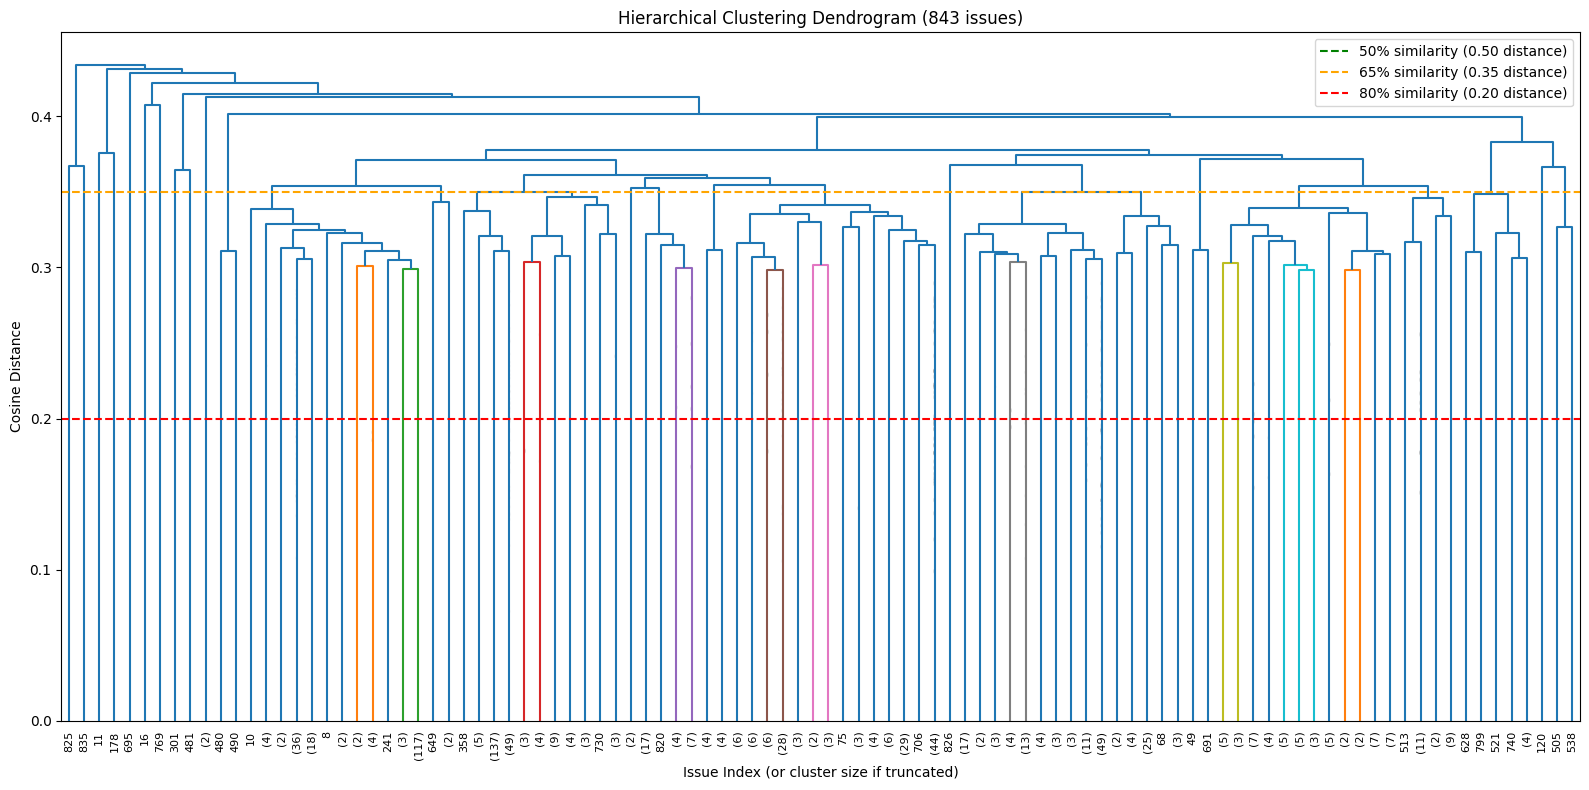

In [33]:
# Dendrogram visualization
# Shows the full hierarchical structure with cut lines at each level

import matplotlib.pyplot as plt

def plot_dendrogram(hier_result, issues, max_display=100, figsize=(16, 8)):
    """Plot a dendrogram with horizontal lines showing the cut thresholds."""
    
    Z = hier_result["linkage"]
    levels = hier_result["levels_config"]
    
    # Truncate for large datasets
    truncate_mode = 'lastp' if len(issues) > max_display else None
    p = max_display if len(issues) > max_display else None
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot dendrogram
    dendro = dendrogram(
        Z,
        ax=ax,
        truncate_mode=truncate_mode,
        p=p,
        leaf_rotation=90,
        leaf_font_size=8,
        show_contracted=True,
    )
    
    # Add horizontal lines for each level threshold
    colors = ['green', 'orange', 'red']
    for i, level in enumerate(levels):
        dist = 1.0 - level
        ax.axhline(y=dist, color=colors[i % len(colors)], linestyle='--', 
                   label=f'{level:.0%} similarity ({dist:.2f} distance)')
    
    ax.set_title(f'Hierarchical Clustering Dendrogram ({len(issues)} issues)')
    ax.set_xlabel('Issue Index (or cluster size if truncated)')
    ax.set_ylabel('Cosine Distance')
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

plot_dendrogram(hier_result, issues)

In [34]:
# Compare agglomerative vs vector-like vs centroid-like on CSV labels
import math
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, homogeneity_completeness_v_measure

def _prep_texts(issues, truncate_body_chars=1500):
    def _to_text(val):
        if val is None:
            return ""
        if isinstance(val, str):
            return val
        if isinstance(val, float):
            return "" if np.isnan(val) else str(val)
        return str(val)
    texts = []
    for it in issues:
        title = _to_text(it.get("title")).strip()
        body = _to_text(it.get("body")).strip()
        if truncate_body_chars:
            body = body[:truncate_body_chars]
        txt = f"{title}\n\n{body}".strip()
        texts.append(txt or "[empty]")
    return texts


def embed_texts(texts, model_name="gemini-embedding-001", repo_name=None, force_recompute=False):
    """Embed texts with caching support."""
    repo_name = repo_name or REPO_NAME
    cache_path = get_embedding_path(repo_name, model_name)
    
    if not force_recompute and not FORCE_RECOMPUTE and os.path.exists(cache_path):
        emb = np.load(cache_path)
        if len(emb) == len(texts):
            print(f"Loaded cached embeddings from {cache_path} ({len(emb)} vectors)")
            return emb
        else:
            print(f"Cache size mismatch ({len(emb)} vs {len(texts)} texts), recomputing...")
    
    if model_name.lower().startswith("gemini"):
        if genai_client is None:
            raise RuntimeError("GOOGLE_API_KEY not set; populate .env or environment")
        print(f"Computing embeddings with {model_name}...")

        # Batch embeddings (Gemini has 100 item limit per batch)
        all_embeddings = []
        batch_size = 100
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            print(f"  Embedding batch {i//batch_size + 1}/{(len(texts)-1)//batch_size + 1} ({len(batch)} items)...")
            resp = genai_client.models.embed_content(
                model=model_name,
                contents=batch,
                config={"output_dimensionality": 768},
            )
            all_embeddings.extend([e.values for e in resp.embeddings])
        emb = np.asarray(all_embeddings, dtype=np.float32)
    else:
        print(f"Computing embeddings with {model_name}...")
        model = SentenceTransformer(model_name)
        emb = model.encode(texts, batch_size=32, show_progress_bar=True, normalize_embeddings=True)
        emb = np.asarray(emb, dtype=np.float32)
    
    norms = np.linalg.norm(emb, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    emb = emb / norms
    
    np.save(cache_path, emb)
    print(f"Saved embeddings to {cache_path} ({len(emb)} vectors)")
    
    return emb


def cosine(a, b):
    return float(np.dot(a, b))

def vector_like_cluster(embeddings, threshold=0.72):
    labels = []
    next_cluster = 0
    for i, emb in enumerate(embeddings):
        sims = [cosine(emb, embeddings[j]) for j in range(i)]
        similars = [j for j, s in enumerate(sims) if s >= threshold]
        if similars:
            labels.append(labels[similars[0]])
        else:
            labels.append(next_cluster)
            next_cluster += 1
    return np.array(labels, dtype=int)

def centroid_cluster(embeddings, threshold=0.65):
    centroids = []
    labels = []
    for emb in embeddings:
        if not centroids:
            labels.append(0)
            centroids.append(emb.copy())
            continue
        sims = [cosine(emb, c) for c in centroids]
        best_idx = int(np.argmax(sims))
        if sims[best_idx] >= threshold:
            k = best_idx
            count_k = labels.count(k)
            centroids[k] = (centroids[k] * count_k + emb) / (count_k + 1)
            labels.append(k)
        else:
            labels.append(len(centroids))
            centroids.append(emb.copy())
    return np.array(labels, dtype=int)

def evaluate(true_labels, pred_labels, name):
    true_enc, _ = pd.factorize(pd.Series(true_labels))
    pred_enc, _ = pd.factorize(pd.Series(pred_labels))
    ari = adjusted_rand_score(true_enc, pred_enc)
    ami = adjusted_mutual_info_score(true_enc, pred_enc, average_method="arithmetic")
    h, c, v = homogeneity_completeness_v_measure(true_enc, pred_enc)
    print(f"{name} -> ARI: {ari:.3f} | AMI: {ami:.3f} | H: {h:.3f} C: {c:.3f} V: {v:.3f}")

# Load data (from cache or GitHub)
df_src = load_or_fetch_issues(REPO_NAME)
issues = df_src[["title", "body"]].to_dict("records")
true_labels = df_src["label"].tolist() if "label" in df_src.columns else None
print(f"Loaded {len(issues)} issues")

texts = _prep_texts(issues)
emb = embed_texts(texts, model_name="gemini-embedding-001")

# Agglomerative
res_aggl = cluster_issues(issues, sim_threshold=0.72, min_cluster_size=2, label_singletons_as_minus_one=False)

# Vector-style
vec_labels = vector_like_cluster(emb, threshold=0.72)

# Centroid-style
cent_labels = centroid_cluster(emb, threshold=0.65)

if true_labels is not None:
    evaluate(true_labels, res_aggl["display_labels"], "Agglomerative")
    evaluate(true_labels, vec_labels, "Vector-like")
    evaluate(true_labels, cent_labels, "Centroid-like")
else:
    print("No labels column found; skipping evaluation.")

Loading cached issues from data/facebook__react.csv
Loaded 843 issues
Loaded cached embeddings from embeddings/facebook__react__gemini_embedding_001.npy (843 vectors)
Embedding batch 1/9 (100 items)...
Embedding batch 2/9 (100 items)...
Embedding batch 3/9 (100 items)...
Embedding batch 4/9 (100 items)...
Embedding batch 5/9 (100 items)...
Embedding batch 6/9 (100 items)...
Embedding batch 7/9 (100 items)...
Embedding batch 8/9 (100 items)...
Embedding batch 9/9 (43 items)...
Using Gemini Text Embedding
No labels column found; skipping evaluation.


In [35]:
# Hyperparameter sweep for vector/centroid thresholds
from itertools import product

vector_thresholds = [0.68, 0.70, 0.72, 0.74, 0.76, 0.78]
centroid_thresholds = [0.60, 0.63, 0.66, 0.69, 0.72, 0.75]
agg_thresholds = [0.68, 0.70, 0.72, 0.74, 0.76, 0.78]

results = []
true_labels = df_src["label"].tolist() if "label" in df_src.columns else None
if true_labels is None:
    print("No labels; skipping sweep.")
else:
    true_enc, _ = pd.factorize(pd.Series(true_labels))

    # Vector sweeps
    for vt in vector_thresholds:
        vec_labels = vector_like_cluster(emb, threshold=vt)
        pred_enc, _ = pd.factorize(pd.Series(vec_labels))
        ari = adjusted_rand_score(true_enc, pred_enc)
        ami = adjusted_mutual_info_score(true_enc, pred_enc, average_method="arithmetic")
        h, c, v = homogeneity_completeness_v_measure(true_enc, pred_enc)
        results.append({"method": "vector", "threshold": vt, "ari": ari, "ami": ami, "h": h, "c": c, "v": v})

    # Centroid sweeps
    for ct in centroid_thresholds:
        cent_labels = centroid_cluster(emb, threshold=ct)
        pred_enc, _ = pd.factorize(pd.Series(cent_labels))
        ari = adjusted_rand_score(true_enc, pred_enc)
        ami = adjusted_mutual_info_score(true_enc, pred_enc, average_method="arithmetic")
        h, c, v = homogeneity_completeness_v_measure(true_enc, pred_enc)
        results.append({"method": "centroid", "threshold": ct, "ari": ari, "ami": ami, "h": h, "c": c, "v": v})

    # Agglomerative sweeps
    for th in agg_thresholds:
        dist_threshold = 1.0 - float(th)
        kwargs = dict(n_clusters=None, linkage="average", distance_threshold=dist_threshold)
        if version.parse(sklearn.__version__) >= version.parse("1.2"):
            kwargs["metric"] = "cosine"
        else:
            kwargs["affinity"] = "cosine"
        cl = AgglomerativeClustering(**kwargs)
        labels = cl.fit_predict(emb)
        pred_enc, _ = pd.factorize(pd.Series(labels))
        ari = adjusted_rand_score(true_enc, pred_enc)
        ami = adjusted_mutual_info_score(true_enc, pred_enc, average_method="arithmetic")
        h, c, v = homogeneity_completeness_v_measure(true_enc, pred_enc)
        results.append({"method": "agglomerative", "threshold": th, "ari": ari, "ami": ami, "h": h, "c": c, "v": v})

    df_sweep = pd.DataFrame(results).sort_values(["method", "ari"], ascending=[True, False]).reset_index(drop=True)
    display(df_sweep)

    # Show best per method
    best = df_sweep.sort_values(["method", "ari"], ascending=[True, False]).groupby("method").head(1)
    print("Best per method (by ARI):")
    display(best)

No labels; skipping sweep.


## Vector Visualization

Visualize the high-dimensional embeddings in 2D/3D space using UMAP dimensionality reduction. This helps understand how vectors cluster and whether similar items are actually close together in vector space.

In [36]:
import umap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def _safe_label(val):
    """Convert label to string, handling NaN and None."""
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return "unlabeled"
    return str(val)


def visualize_embeddings_2d(embeddings, true_labels=None, pred_labels=None, texts=None, titles=None):
    """
    Reduce embeddings to 2D using UMAP and create interactive visualizations.
    
    Args:
        embeddings: numpy array of shape (n_samples, n_features)
        true_labels: ground truth labels (optional)
        pred_labels: predicted cluster labels (optional)
        texts: list of text content for hover display (optional)
        titles: list of titles for each point (optional)
    """
    print("Reducing dimensions with UMAP (2D)...")
    reducer_2d = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    embedding_2d = reducer_2d.fit_transform(embeddings)
    
    # Normalize labels to handle NaN
    if true_labels is not None:
        true_labels = [_safe_label(l) for l in true_labels]
    if pred_labels is not None:
        pred_labels = [_safe_label(l) for l in pred_labels]
    
    # Prepare hover text
    hover_texts = []
    for i in range(len(embeddings)):
        hover = f"Index: {i}<br>"
        if titles is not None and i < len(titles):
            title = titles[i]
            # Handle NaN or non-string values
            if title is None or (isinstance(title, float) and np.isnan(title)):
                title = ""
            else:
                title = str(title)[:100]  # truncate long titles
            hover += f"Title: {title}<br>"
        if true_labels is not None:
            hover += f"True Label: {true_labels[i]}<br>"
        if pred_labels is not None:
            hover += f"Predicted: {pred_labels[i]}<br>"
        hover_texts.append(hover)
    
    # Create figure(s)
    if true_labels is not None and pred_labels is not None:
        # Side-by-side comparison
        fig = make_subplots(
            rows=1, cols=2,
            subplot_titles=("Ground Truth Labels", "Predicted Clusters"),
            horizontal_spacing=0.1
        )
        
        # Ground truth plot
        for label in sorted(set(true_labels)):
            mask = [tl == label for tl in true_labels]
            indices = [i for i, m in enumerate(mask) if m]
            fig.add_trace(
                go.Scatter(
                    x=embedding_2d[indices, 0],
                    y=embedding_2d[indices, 1],
                    mode='markers',
                    name=f'True {label}',
                    text=[hover_texts[i] for i in indices],
                    hovertemplate='%{text}<extra></extra>',
                    marker=dict(size=8, opacity=0.7),
                    legendgroup='true'
                ),
                row=1, col=1
            )
        
        # Predicted clusters plot
        for label in sorted(set(pred_labels)):
            mask = [pl == label for pl in pred_labels]
            indices = [i for i, m in enumerate(mask) if m]
            fig.add_trace(
                go.Scatter(
                    x=embedding_2d[indices, 0],
                    y=embedding_2d[indices, 1],
                    mode='markers',
                    name=f'Pred {label}',
                    text=[hover_texts[i] for i in indices],
                    hovertemplate='%{text}<extra></extra>',
                    marker=dict(size=8, opacity=0.7),
                    legendgroup='pred'
                ),
                row=1, col=2
            )
        
        fig.update_xaxes(title_text="UMAP Dimension 1", row=1, col=1)
        fig.update_xaxes(title_text="UMAP Dimension 1", row=1, col=2)
        fig.update_yaxes(title_text="UMAP Dimension 2", row=1, col=1)
        fig.update_yaxes(title_text="UMAP Dimension 2", row=1, col=2)
        
        fig.update_layout(
            height=600,
            width=1400,
            title_text="2D Vector Space Visualization",
            showlegend=True
        )
        
    elif pred_labels is not None:
        # Just predicted labels
        df_plot = pd.DataFrame({
            'x': embedding_2d[:, 0],
            'y': embedding_2d[:, 1],
            'cluster': pred_labels,
            'hover': hover_texts
        })
        
        fig = px.scatter(
            df_plot, x='x', y='y', color='cluster',
            hover_data={'hover': True, 'x': False, 'y': False, 'cluster': False},
            title='2D Vector Space - Predicted Clusters',
            labels={'x': 'UMAP Dimension 1', 'y': 'UMAP Dimension 2'}
        )
        fig.update_traces(marker=dict(size=8, opacity=0.7))
        fig.update_layout(height=600, width=900)
        
    elif true_labels is not None:
        # Just ground truth
        df_plot = pd.DataFrame({
            'x': embedding_2d[:, 0],
            'y': embedding_2d[:, 1],
            'label': true_labels,
            'hover': hover_texts
        })
        
        fig = px.scatter(
            df_plot, x='x', y='y', color='label',
            hover_data={'hover': True, 'x': False, 'y': False, 'label': False},
            title='2D Vector Space - Ground Truth Labels',
            labels={'x': 'UMAP Dimension 1', 'y': 'UMAP Dimension 2'}
        )
        fig.update_traces(marker=dict(size=8, opacity=0.7))
        fig.update_layout(height=600, width=900)
    else:
        # No labels - just show points
        df_plot = pd.DataFrame({
            'x': embedding_2d[:, 0],
            'y': embedding_2d[:, 1],
            'hover': hover_texts
        })
        
        fig = px.scatter(
            df_plot, x='x', y='y',
            hover_data={'hover': True, 'x': False, 'y': False},
            title='2D Vector Space',
            labels={'x': 'UMAP Dimension 1', 'y': 'UMAP Dimension 2'}
        )
        fig.update_traces(marker=dict(size=8, opacity=0.7))
        fig.update_layout(height=600, width=900)
    
    fig.show()
    return embedding_2d


def visualize_embeddings_3d(embeddings, true_labels=None, pred_labels=None, texts=None, titles=None):
    """
    Reduce embeddings to 3D using UMAP and create interactive 3D visualization.
    """
    print("Reducing dimensions with UMAP (3D)...")
    reducer_3d = umap.UMAP(n_components=3, random_state=42, n_neighbors=15, min_dist=0.1)
    embedding_3d = reducer_3d.fit_transform(embeddings)
    
    # Normalize labels to handle NaN
    if true_labels is not None:
        true_labels = [_safe_label(l) for l in true_labels]
    if pred_labels is not None:
        pred_labels = [_safe_label(l) for l in pred_labels]
    
    # Prepare hover text
    hover_texts = []
    for i in range(len(embeddings)):
        hover = f"Index: {i}<br>"
        if titles is not None and i < len(titles):
            title = titles[i]
            # Handle NaN or non-string values
            if title is None or (isinstance(title, float) and np.isnan(title)):
                title = ""
            else:
                title = str(title)[:100]
            hover += f"Title: {title}<br>"
        if true_labels is not None:
            hover += f"True Label: {true_labels[i]}<br>"
        if pred_labels is not None:
            hover += f"Predicted: {pred_labels[i]}<br>"
        hover_texts.append(hover)
    
    # Use predicted labels if available, otherwise true labels
    labels_to_plot = pred_labels if pred_labels is not None else true_labels
    label_name = "Predicted Cluster" if pred_labels is not None else "Ground Truth Label"
    
    if labels_to_plot is not None:
        df_plot = pd.DataFrame({
            'x': embedding_3d[:, 0],
            'y': embedding_3d[:, 1],
            'z': embedding_3d[:, 2],
            'label': labels_to_plot,
            'hover': hover_texts
        })
        
        fig = px.scatter_3d(
            df_plot, x='x', y='y', z='z', color='label',
            hover_data={'hover': True, 'x': False, 'y': False, 'z': False, 'label': False},
            title=f'3D Vector Space - {label_name}',
            labels={'x': 'UMAP Dim 1', 'y': 'UMAP Dim 2', 'z': 'UMAP Dim 3'}
        )
    else:
        df_plot = pd.DataFrame({
            'x': embedding_3d[:, 0],
            'y': embedding_3d[:, 1],
            'z': embedding_3d[:, 2],
            'hover': hover_texts
        })
        
        fig = px.scatter_3d(
            df_plot, x='x', y='y', z='z',
            hover_data={'hover': True, 'x': False, 'y': False, 'z': False},
            title='3D Vector Space',
            labels={'x': 'UMAP Dim 1', 'y': 'UMAP Dim 2', 'z': 'UMAP Dim 3'}
        )
    
    fig.update_traces(marker=dict(size=5, opacity=0.7))
    fig.update_layout(height=700, width=900)
    fig.show()
    return embedding_3d

In [37]:
# Visualize the embeddings in 2D space
# This shows ground truth labels vs predicted clusters side-by-side

titles = [issue.get("title", "") for issue in issues]
embedding_2d = visualize_embeddings_2d(
    emb, 
    true_labels=true_labels,
    pred_labels=res_aggl["display_labels"],
    titles=titles
)

Reducing dimensions with UMAP (2D)...


/Users/nagakarumuri/Documents/development/text-clustering/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [38]:
# Visualize in 3D - interactive, can rotate and zoom
# Shows predicted clusters by default

embedding_3d = visualize_embeddings_3d(
    emb,
    true_labels=true_labels,
    pred_labels=res_aggl["display_labels"],
    titles=titles
)

Reducing dimensions with UMAP (3D)...


/Users/nagakarumuri/Documents/development/text-clustering/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Vector Similarity Explorer

Explore which items are most similar to each other in vector space. This helps understand what the embeddings consider "similar".

In [39]:
def _safe_str(val, max_len=None):
    """Convert value to string, handling NaN and None."""
    if val is None or (isinstance(val, float) and np.isnan(val)):
        return ""
    s = str(val)
    if max_len:
        s = s[:max_len]
    return s


def find_most_similar(embeddings, query_idx, top_k=10, issues=None):
    """
    Find the most similar items to a given query item.
    
    Args:
        embeddings: numpy array of embeddings
        query_idx: index of the query item
        top_k: number of most similar items to return
        issues: list of issue dicts with 'title' and 'body' (optional)
    
    Returns:
        DataFrame with similarity scores and content
    """
    query_emb = embeddings[query_idx]
    
    # Compute cosine similarities
    similarities = np.dot(embeddings, query_emb)
    
    # Get top-k most similar (excluding the query itself)
    similar_indices = np.argsort(similarities)[::-1]
    similar_indices = [i for i in similar_indices if i != query_idx][:top_k]
    
    results = []
    for idx in similar_indices:
        row = {
            'idx': idx,
            'similarity': float(similarities[idx]),
        }
        if issues is not None:
            row['title'] = _safe_str(issues[idx].get('title', ''), 100)
            row['body'] = _safe_str(issues[idx].get('body', ''), 200)
        results.append(row)
    
    df = pd.DataFrame(results)
    
    # Show query item
    print(f"Query item [{query_idx}]:")
    if issues is not None:
        print(f"  Title: {_safe_str(issues[query_idx].get('title', ''), 100)}")
        print(f"  Body: {_safe_str(issues[query_idx].get('body', ''), 200)}")
    print(f"\nMost similar items:")
    
    return df


def visualize_similarity_heatmap(embeddings, indices=None, labels=None, max_items=50):
    """
    Create a heatmap showing pairwise similarities between items.
    
    Args:
        embeddings: numpy array of embeddings
        indices: specific indices to visualize (optional, defaults to first max_items)
        labels: labels for each item (optional)
        max_items: maximum number of items to show (for performance)
    """
    if indices is None:
        indices = list(range(min(len(embeddings), max_items)))
    
    # Compute similarity matrix for selected indices
    selected_embs = embeddings[indices]
    similarity_matrix = np.dot(selected_embs, selected_embs.T)
    
    # Create labels for axes (handle NaN labels)
    if labels is not None:
        tick_labels = [f"{i} (L{_safe_label(labels[i])})" for i in indices]
    else:
        tick_labels = [str(i) for i in indices]
    
    # Create heatmap
    fig = go.Figure(data=go.Heatmap(
        z=similarity_matrix,
        x=tick_labels,
        y=tick_labels,
        colorscale='RdBu',
        zmid=0.7,  # center the colorscale at typical similarity threshold
        colorbar=dict(title="Cosine Similarity")
    ))
    
    fig.update_layout(
        title=f'Pairwise Similarity Heatmap ({len(indices)} items)',
        xaxis_title='Item Index',
        yaxis_title='Item Index',
        width=800,
        height=800
    )
    
    fig.show()
    return similarity_matrix

In [40]:
# Example: Find items most similar to item 0
df_similar = find_most_similar(emb, query_idx=0, top_k=10, issues=issues)
display(df_similar)

Query item [0]:
  Title: Bug: The ESLint react-hooks/immutability rule warns against using a callback internally
  Body: eslint-plugin-react-hooks version: 7.0.1

## Steps To Reproduce

```tsx
const Test: FC = () => {
    const onMouseDown = useCallback(() => {
        // warns here about using onMouseDown
        windo

Most similar items:


,idx,similarity,title,body
0,114,0.807251,[Compiler Bug]: react-hooks/immutability false...,### What kind of issue is this?\n\n- [ ] React...
1,180,0.805585,[Compiler Bug]: False positive for “impure fun...,### What kind of issue is this?\n\n- [ ] React...
2,687,0.799452,eslint-plugin-react-hooks suggests adding a de...,"If you write:\r\n\r\n```js\r\nimport React, {u..."
3,110,0.795902,Bug: `eslint-plugin-react-hooks` causes weird ...,<!--\n Please provide a clear and concise des...
4,130,0.788244,"[Compiler Bug]: Incorrect immutability error ""...",### What kind of issue is this?\n\n- [ ] React...
5,287,0.787275,"[Compiler Bug]: Incorrect ""Writing to a variab...",### What kind of issue is this?\n\n- [ ] React...
6,72,0.784943,Bug: eslint-react-hooks false positives on imm...,As in [#34776](https://github.com/facebook/rea...
7,280,0.784337,[Compiler Bug]: ESLint Compiler rules do not a...,### What kind of issue is this?\r\n\r\n- [ ] R...
8,136,0.782904,Bug: react-hooks/set-state-in-effect false pos...,"**React version:** `react@19.2.0`, `eslint-plu..."
9,41,0.782259,"Bug: eslint-plugin-react-hooks not throwing ""H...",React version: 19.2.\n\n## Steps To Reproduce\...


In [41]:
# Visualize pairwise similarities as a heatmap
# This shows which items are similar to each other
# Darker red = more similar, darker blue = less similar

sim_matrix = visualize_similarity_heatmap(
    emb, 
    indices=None,  # Uses first 50 items by default
    labels=true_labels,
    max_items=50
)

## Compare Results Across Repos

Load and compare clustering results from all analyzed repos.

In [42]:
# Load all results and compare across repos
all_results = load_all_results()

if all_results is not None:
    # Summary by repo
    summary = all_results.groupby("repo").agg({
        "idx": "count",
        "cluster_display": "nunique", 
        "is_singleton": "sum",
        "cluster_size": "mean"
    }).rename(columns={
        "idx": "total_issues",
        "cluster_display": "n_clusters",
        "is_singleton": "n_singletons",
        "cluster_size": "avg_cluster_size"
    })
    summary["pct_clustered"] = 100 * (summary["total_issues"] - summary["n_singletons"]) / summary["total_issues"]
    summary = summary.round(1)
    
    print("=" * 70)
    print("COMPARISON ACROSS REPOS")
    print("=" * 70)
    display(summary)
    
    # Show top clusters from each repo
    print("\n" + "=" * 70)
    print("TOP CLUSTERS BY REPO (showing largest cluster from each)")
    print("=" * 70)
    
    for repo in all_results["repo"].unique():
        repo_df = all_results[all_results["repo"] == repo]
        largest_cluster = repo_df[~repo_df["is_singleton"]].groupby("cluster_display").size().idxmax()
        cluster_issues = repo_df[repo_df["cluster_display"] == largest_cluster]
        
        print(f"\n{repo} - Cluster {largest_cluster} ({len(cluster_issues)} issues):")
        for _, row in cluster_issues.head(5).iterrows():
            print(f"  - {row['title'][:80]}")

Loaded results from 5 repos (1516 total issues)
COMPARISON ACROSS REPOS


,total_issues,n_clusters,n_singletons,avg_cluster_size,pct_clustered
repo,,,,,
altock/soulcaster,87,58,0,1.9,100.0
facebook/react,843,149,0,40.6,100.0
naga-k/bad-ux-mart,56,29,0,2.8,100.0
naga-k/math_functions_soulcaster,30,16,0,2.7,100.0
plotly/plotly.js,500,182,0,6.2,100.0



TOP CLUSTERS BY REPO (showing largest cluster from each)

altock/soulcaster - Cluster 2 (4 issues):
  - Check coding agent runtimes (E2B vs ECS/Fargate vs local)
  - Run coding agent on AWS Fargate triggered via Vercel API
  - Decide model/provider for coding agent (Gemini via Kilocode)
  - Decide where to run Soulcaster (hosting/runtime)

naga-k/math_functions_soulcaster - Cluster 0 (4 issues):
  - UserManager.delete_user seems to be a no-op
  - Users still exist after calling delete_user
  - Memory leak? Users not being deleted.
  - delete_user method doesn't remove the user from the list

naga-k/bad-ux-mart - Cluster 11 (5 issues):
  - modulo function also has zero division issue
  - Unhandled exception in math_ops
  - App crashes when dividing by zero
  - Need input validation in divide function
  - ZeroDivisionError in math_ops.divide

plotly/plotly.js - Cluster 63 (20 issues):
  - [BUG]: Coupled hoverinfo tooltips are misaligned
  - Cannot display a tooltip label showing the two